# А/А-тестирование мобильного приложения

**Задание:** Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.  
Описание данных: 
- uid - id пользователя
- experimentVariant – вариант эксперимента
- version – версия приложения
- purchase – факт покупки

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';')

In [3]:
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [5]:
df.shape

(127018, 4)

In [6]:
df.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [7]:
df.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

Запускаем A/A-тест

  0%|          | 0/1000 [00:00<?, ?it/s]

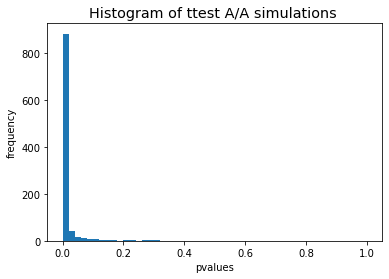

0.935

In [8]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# рассчитываем FPR
sum(np.array(res) < 0.05) / simulations

FPR > 0.05, значит будем искать причины поломки сплит-системы

In [9]:
# конверсия в покупку и количество в группах по варианту эксперимента и версиям приложения 
(
    df
    .groupby(['experimentVariant', 'version'], as_index=False)
    .agg({'purchase': 'mean', 'uid': 'count'})
    .rename(columns={'purchase': 'cr', 'uid': 'count'})
)

,experimentVariant,version,cr,count
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Очевидно, что количественно разбиение по версиям примерно одинаково между соответствующими вариантами эксперимента, но у группы экспериментального варианта "0" в версии МП "v2.8.0" CR существенно ниже аналогичного показателя в варианте "1". 

Посчитаем pvalue для каждой версии МП:

In [10]:
s1 = df.query('experimentVariant == 0 & version == "v2.8.0"').purchase
s2 = df.query('experimentVariant == 1 & version == "v2.8.0"').purchase
stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=-43.097051598551076, pvalue=0.0)

In [11]:
s1 = df.query('experimentVariant == 0 & version == "v2.9.0"').purchase
s2 = df.query('experimentVariant == 1 & version == "v2.9.0"').purchase
stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=0.997860971925487, pvalue=0.31835686930247525)

In [12]:
s1 = df.query('experimentVariant == 0 & version == "v3.7.4.0"').purchase
s2 = df.query('experimentVariant == 1 & version == "v3.7.4.0"').purchase
stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=-0.5875202960070302, pvalue=0.5568700784122844)

In [13]:
s1 = df.query('experimentVariant == 0 & version == "v3.8.0.0"').purchase
s2 = df.query('experimentVariant == 1 & version == "v3.8.0.0"').purchase
stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=-1.1973368830477649, pvalue=0.2311993431794881)

Только в версии МП "v2.8.0" видим статистически значимые различия (pvalue < 0.05). Исключим данную версию из основного датафрейма и запустим повторно A/A-тест.

  0%|          | 0/1000 [00:00<?, ?it/s]

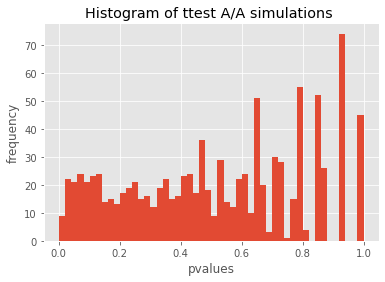

0.041

In [14]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 0) & (df.version != "v2.8.0")].purchase.sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 1) & (df.version != "v2.8.0")].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# рассчитываем FPR
sum(np.array(res) < 0.05) / simulations

Т.к. после исключения данных по версии МП "v2.8.0" FPR стал меньше 0.05, то можно сказать, что мы нашли причину поломки сплит-системы и расхождения А/А теста на полных данных.

**Выводы:** после проведения А/А теста на полных данных получили показатель проверки качества сплит-системы FPR равный 0.935. FPR больше порогового значения альфа в 0.05, что говорит о наличии поломки в сплит-системе. Посчитав конверсию (коэффициент покупок) и количество пользователей в каждой версии МП по экспериментальным вариантам, было обнаружено аномально низкое значение CR (0.000993) в версии МП "v2.8.0" у экспериментального варианта "0". Расчёт pvalue при сравнении по версиям МП показал статистически значимые различия у версии МП "v2.8.0", что указывает на связь поломки именно с данной версией МП. При повторном проведении А/А теста без данных по версии МП "v2.8.0" FPR стал равным 0.041, что меньше 0.05, следовательно поломка в сплит-системе связана с версией МП "v2.8.0".